In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import seaborn as sns
from sigvisa import Sigvisa
import numpy as np

import scipy.stats
from sigvisa.database.signal_data import execute_and_return_id
from sigvisa.learn.train_param_common import insert_model
import os

from sigvisa.models.noise.noise_model import NoiseModel
from sigvisa.models.distributions import Gaussian, TruncatedGaussian, InvGamma, MultiGaussian
from sigvisa.utils.fileutils import mkdir_p

In [2]:


def noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, param):
    prefix="parameters/runs/"
    s = Sigvisa()
    fdir = os.path.join(prefix, "noise_%d" % runid, sta, chan, band, "hz_%.2f" % hz)
    mkdir_p(os.path.join(s.homedir, fdir))
    env_s = "env" if env else "raw"
    fname = "%s_np%d_%s.pkl" % (param, n_p, env_s)
    return os.path.join(fdir, fname)

    
def train_noise_mean_priors(runid, sta, band, hz, env, mean_upper_cutoff=None, mean_lower_cutoff=None, chan=None, n_p=None):

    
    np_cond = ("and nm.n_p=%d" %n_p) if n_p is not None else ""
    fit_conds = "fit.runid=%d and fit.sta='%s' and fit.band='%s' and fit.chan='%s' and fit.hz=%f and fit.env='%s'" %\
                (runid, sta, band, chan, hz, 't' if env else 'f')
    sql_query = "select nm.fname from sigvisa_coda_fit fit, sigvisa_noise_model nm where nm.nmid = fit.nmid and %s %s" % (fit_conds, np_cond)
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    
    cursor.execute(sql_query)
    fnames = cursor.fetchall()
    models = []
    for fname in fnames:
        try:
            model = NoiseModel.load_from_file(fname[0], "ar")
        except:
            continue
        models.append(model)
    
    means = np.array([nm.c for nm in models])
    stds = np.array([nm.em.std for nm in models])
    params = [np.array(nm.params) for nm in models]
    n_ps = [len(p) for p in params]
    r = scipy.stats.mode(n_ps)    
    n_p = r.mode[0]
    params = np.array([ p for p in params if len(p)==n_p])
    
    means_cutoff = np.percentile(means, 90)
    if mean_upper_cutoff is not None:
        means_cutoff = min(mean_upper_cutoff, means_cutoff)
    stds_cutoff = np.percentile(stds, 90)
    
    censored_means = []
    censored_stds = []
    censored_params = []
    for nm in models:
        if len(nm.params) != n_p: continue
        if nm.c > means_cutoff: continue
        if nm.em.std > stds_cutoff: continue
        if mean_lower_cutoff is not None:
            if nm.c < mean_lower_cutoff: continue
            
        censored_means.append(nm.c)
        censored_stds.append(nm.em.std)
        censored_params.append(nm.params)
    censored_means = np.array(censored_means)
    censored_stds = np.array(censored_stds)
    censored_params = np.array(censored_params)
    
    nfits = len(censored_means)
    if nfits < 5:
        print "not enough fits for", sta
        print sql_query
        return

        
    
    plt.figure()
    
    sns.distplot(censored_means)
    fit_loc, fit_scale = scipy.stats.norm.fit(censored_means)
    if env:
        mean_model = TruncatedGaussian(fit_loc, std=fit_scale, a=0)
        mtype="tgaussian"
    else:
        mean_model = Gaussian(fit_loc, std=fit_scale, a=0)
        mtype="gaussian"
    xs = np.linspace(0, np.max(censored_means), 100)
    meanlps = np.array([np.exp(mean_model.log_p(x)) for x in xs])
    plt.plot(xs, meanlps)
    plt.title("%s means" % sta)
    
    phase_name = "noise_%s" % ("env" if env else "raw")
    mean_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "mean")
    mean_model.dump_to_file(os.path.join(s.homedir, mean_fname))
    insert_model(s.dbconn, runid, "armean", sta, chan, band, phase_name, 
                 model_type=mtype, model_fname=mean_fname, training_set_fname="", 
                 training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                 min_amp=0.0, elapsed=0.0, hyperparams=repr((fit_loc, fit_scale)))
    print mean_fname
    
    
    plt.figure()
    censored_vars = censored_stds**2
    sns.distplot(censored_vars)
    fit_alpha, fit_loc, fit_beta = scipy.stats.invgamma.fit(censored_vars, floc=0.0)
    var_model = InvGamma(alpha=fit_alpha, beta=fit_beta)
    xs = np.linspace(0, np.max(censored_vars), 100)
    varlps = np.array([np.exp(var_model.log_p(x)) for x in xs])
    plt.plot(xs, varlps)
    plt.title("%s stds" % sta)
    
    var_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "arvar")
    var_model.dump_to_file(os.path.join(s.homedir, var_fname))
    insert_model(s.dbconn, runid, "arvar", sta, chan, band, phase_name, 
                 model_type="invgamma", model_fname=var_fname, training_set_fname="", 
                 training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                 min_amp=0.0, elapsed=0.0, hyperparams=repr((fit_alpha, fit_beta)))
    print var_fname
    
    
    mean_params = np.mean(censored_params, axis=0)
    param_cov = np.cov(censored_params.T) + np.eye(n_p) * 0.2
    param_model = MultiGaussian(mean_params, param_cov)
    print "params mean", mean_params
    print "params cov", param_cov
    
    
    param_fname = noise_model_model_fname(runid, sta, band, chan, hz, env, n_p, "arparams")
    param_model.dump_to_file(os.path.join(s.homedir, param_fname))
    insert_model(s.dbconn, runid, "arparams", sta, chan, band, phase_name, 
                 model_type="multigaussian", model_fname=param_fname, training_set_fname="", 
                 training_ll=0.0, require_human_approved=False, max_acost=0.0, n_evids=nfits, 
                 min_amp=0.0, elapsed=0.0, hyperparams=repr((mean_params, param_cov)))
    print param_fname
    
    

    

AS12 SHZ
parameters/runs/noise_1/AS12/SHZ/freq_0.8_4.5/hz_5.00/mean_np3_env.pkl
parameters/runs/noise_1/AS12/SHZ/freq_0.8_4.5/hz_5.00/arvar_np3_env.pkl
params mean [ 0.90549512 -0.25326744  0.13765387]
params cov [[ 0.33184113 -0.0957684  -0.01153072]
 [-0.0957684   0.28443616 -0.00260016]
 [-0.01153072 -0.00260016  0.21091326]]
parameters/runs/noise_1/AS12/SHZ/freq_0.8_4.5/hz_5.00/arparams_np3_env.pkl
FITZ BHZ
parameters/runs/noise_1/FITZ/BHZ/freq_0.8_4.5/hz_5.00/mean_np3_env.pkl
parameters/runs/noise_1/FITZ/BHZ/freq_0.8_4.5/hz_5.00/arvar_np3_env.pkl
params mean [ 1.22802888 -0.51341461  0.12325968]
params cov [[ 0.24451859 -0.04934681  0.01041383]
 [-0.04934681  0.2597978  -0.01592473]
 [ 0.01041383 -0.01592473  0.20682397]]
parameters/runs/noise_1/FITZ/BHZ/freq_0.8_4.5/hz_5.00/arparams_np3_env.pkl
IL31 BHZ
parameters/runs/noise_1/IL31/BHZ/freq_0.8_4.5/hz_5.00/mean_np3_env.pkl
parameters/runs/noise_1/IL31/BHZ/freq_0.8_4.5/hz_5.00/arvar_np3_env.pkl
params mean [ 0.51791797 -0.31930117

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


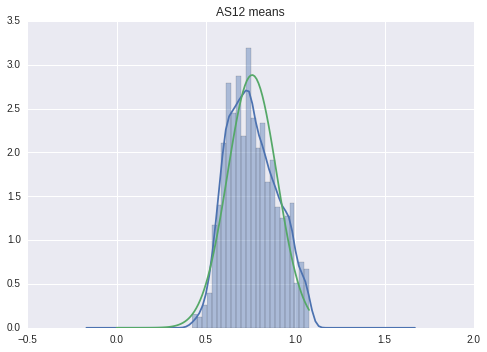

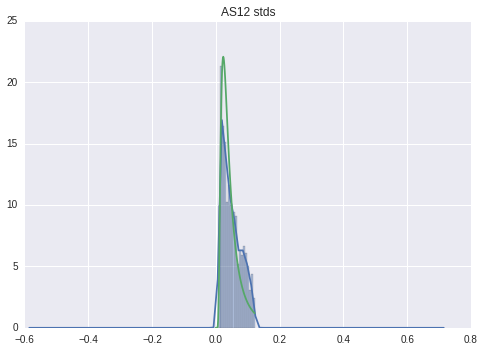

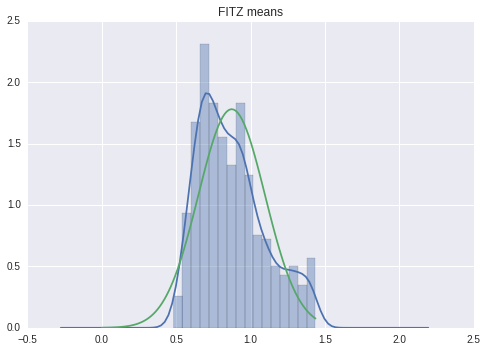

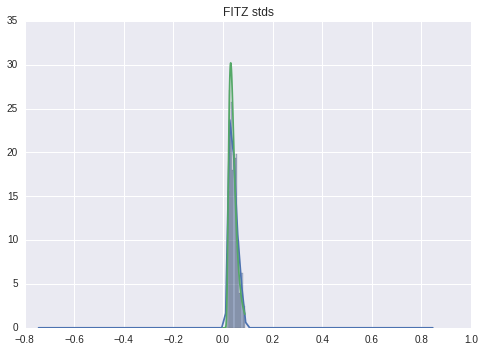

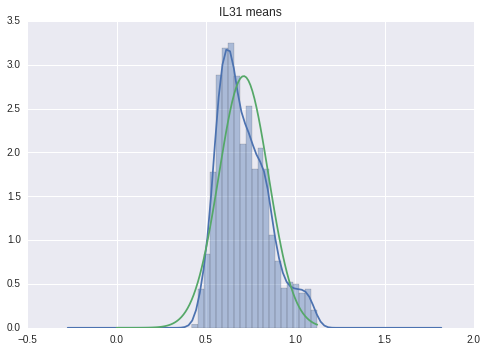

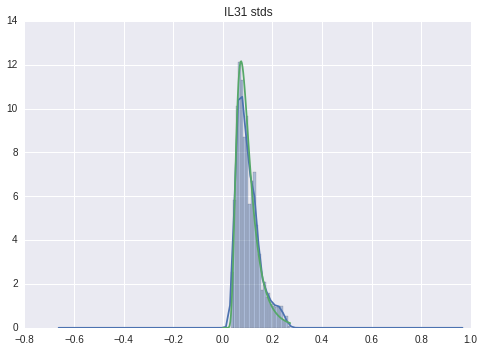

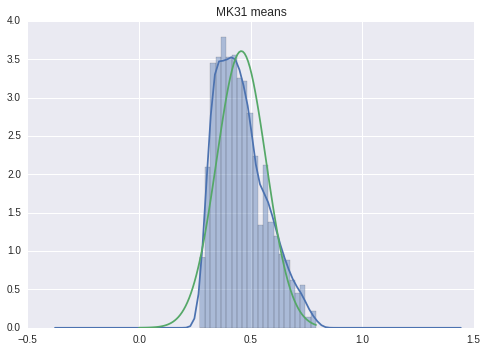

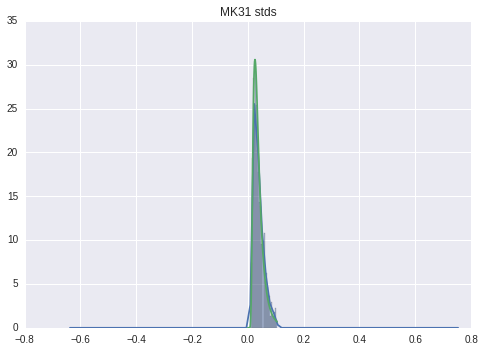

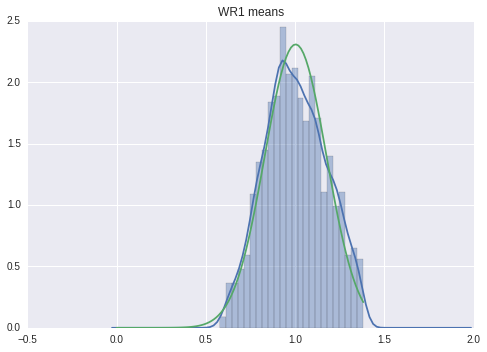

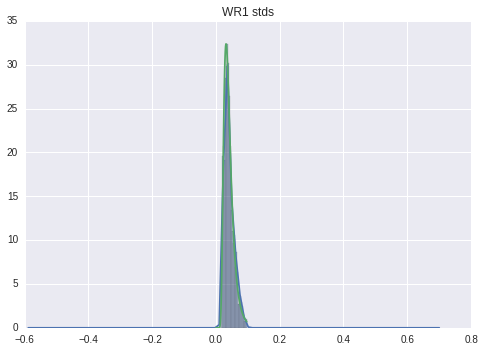

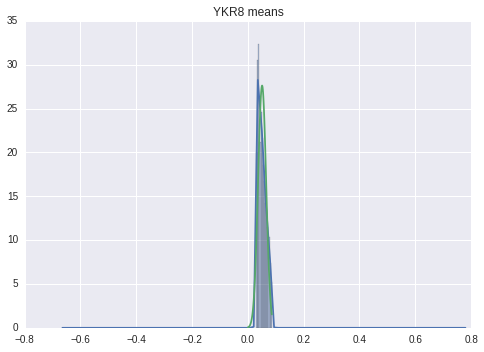

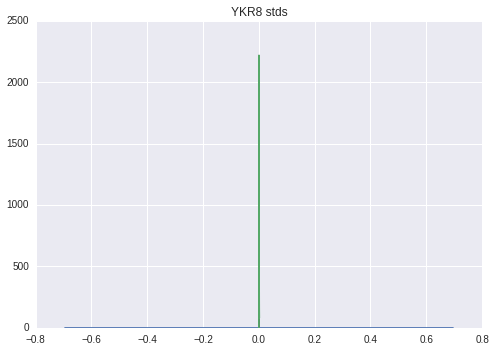

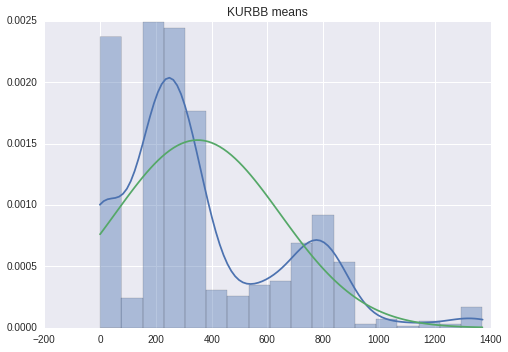

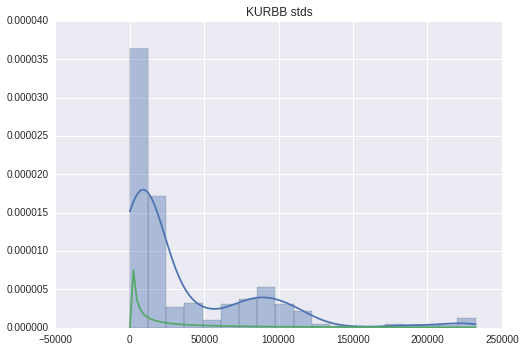

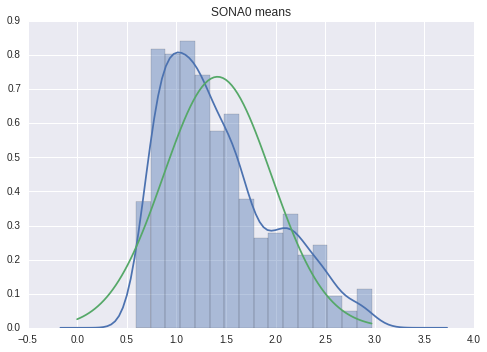

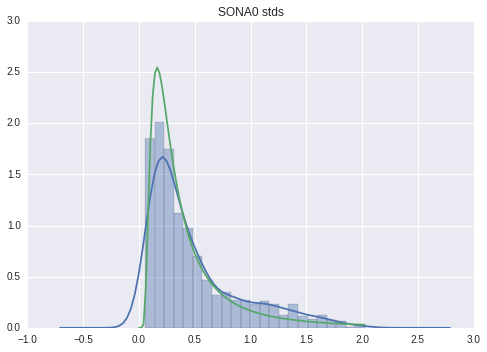

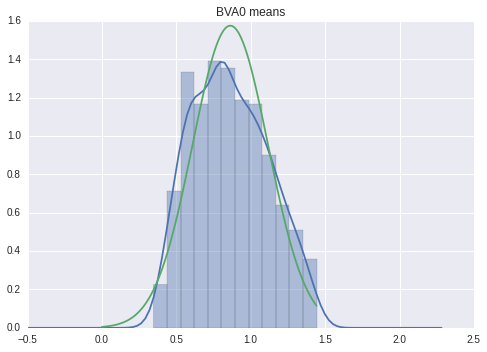

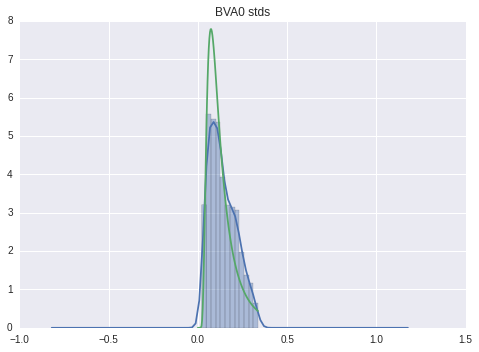

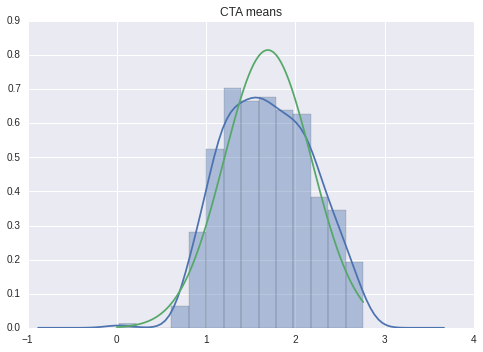

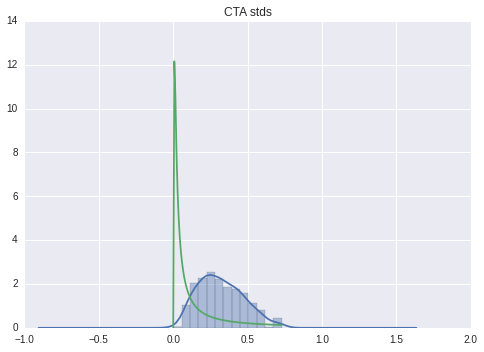

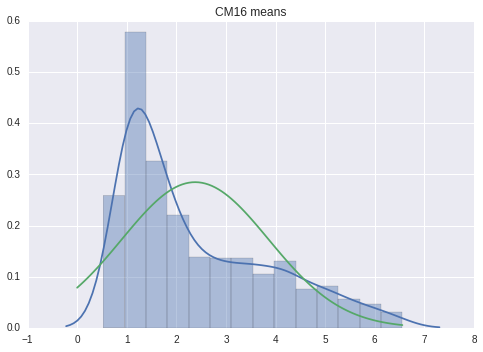

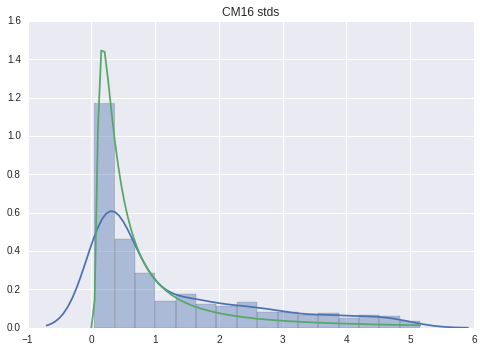

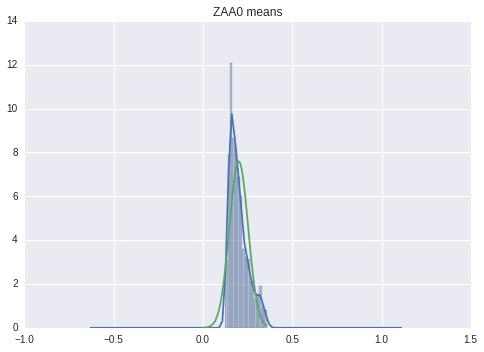

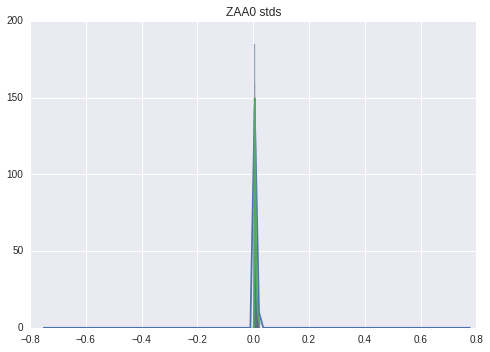

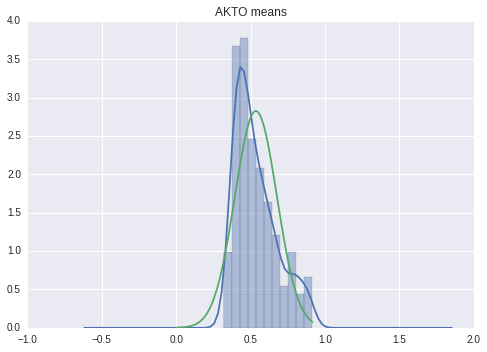

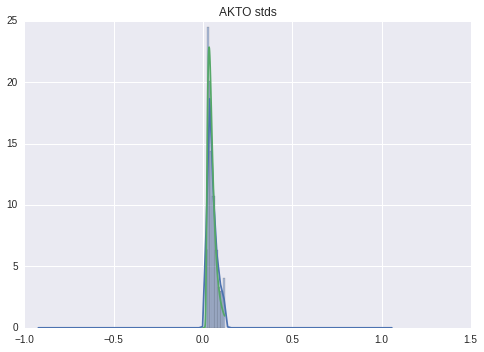

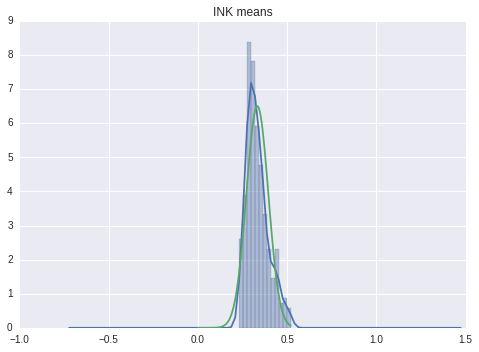

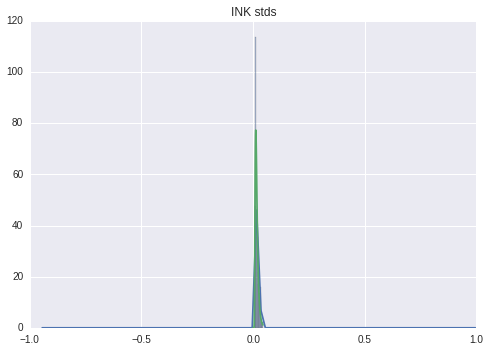

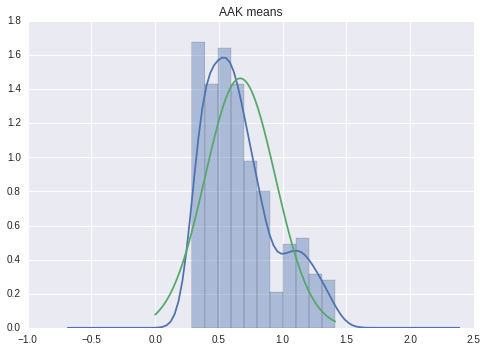

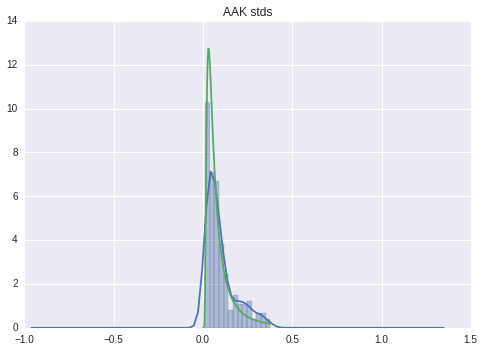

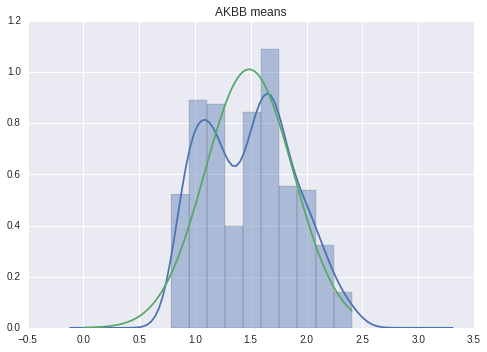

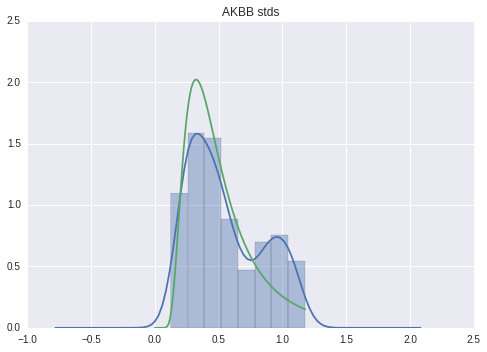

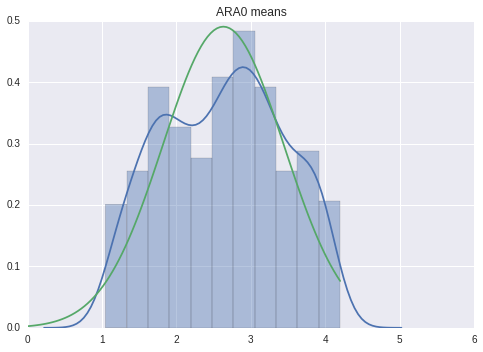

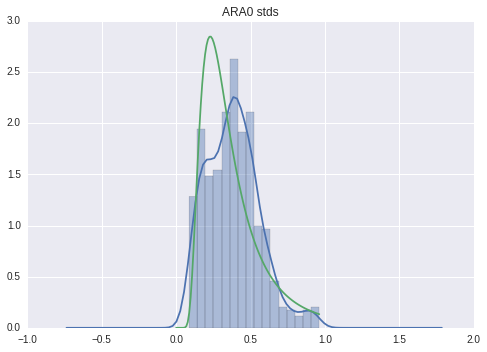

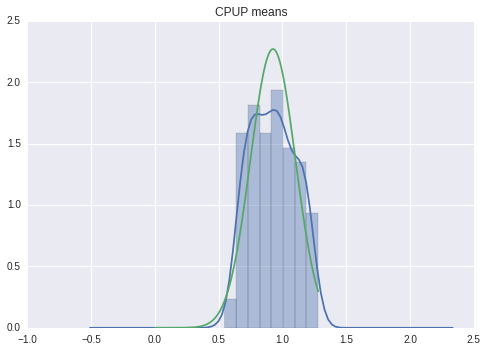

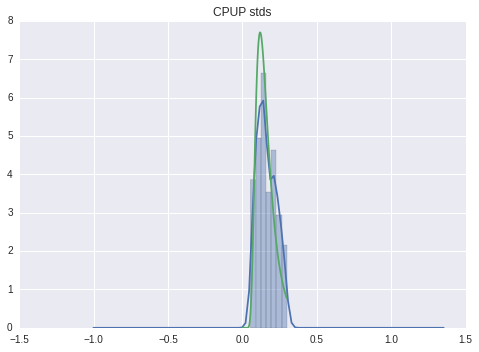

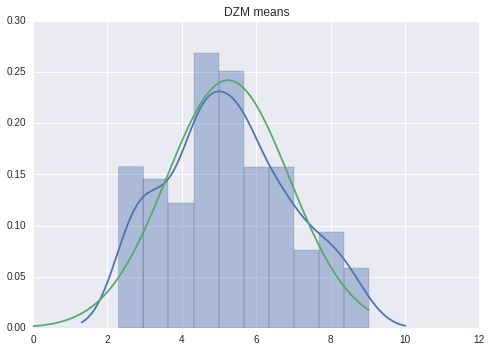

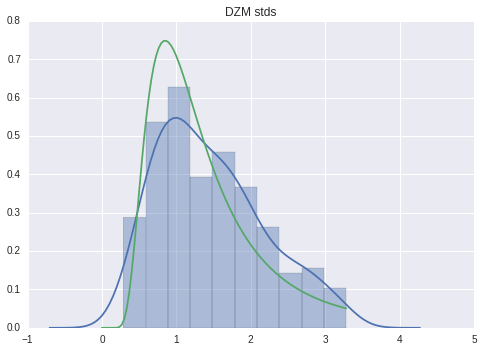

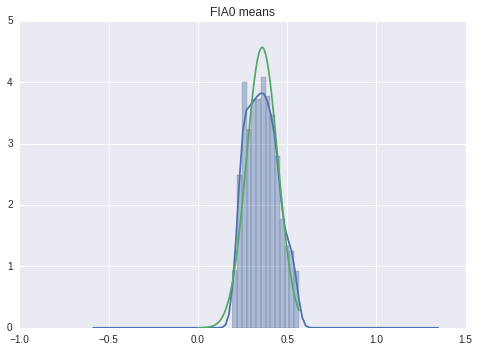

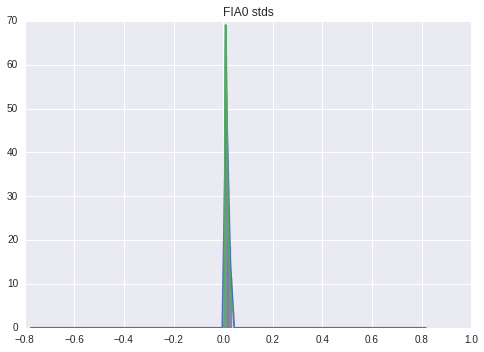

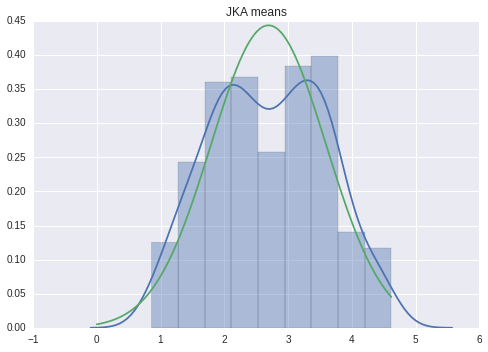

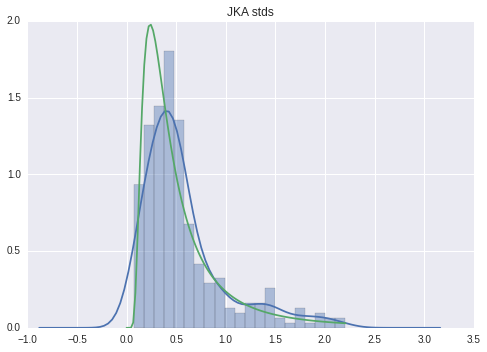

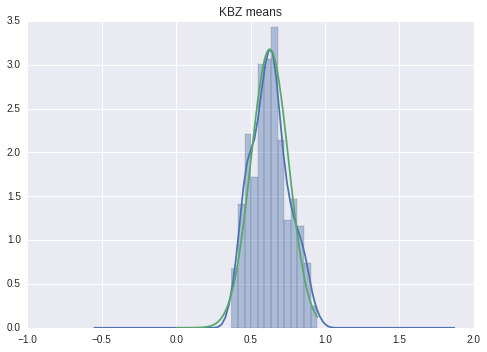

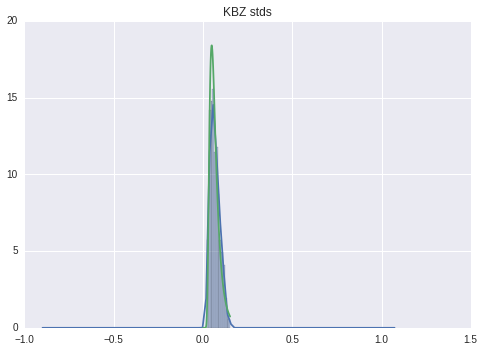

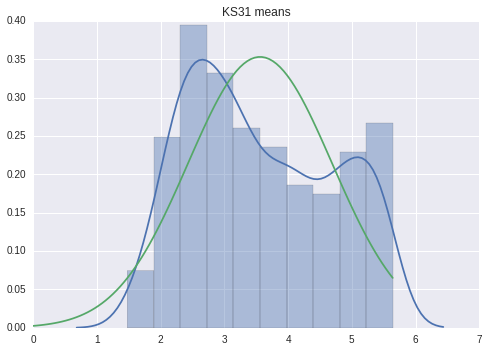

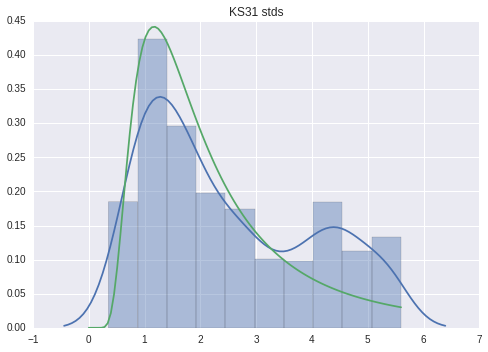

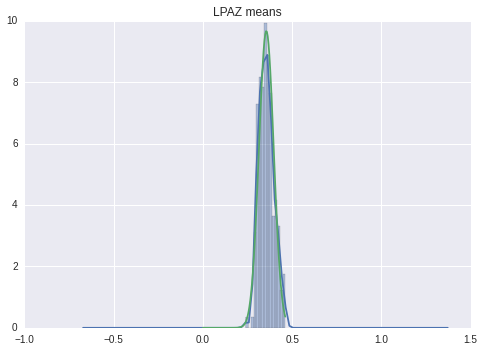

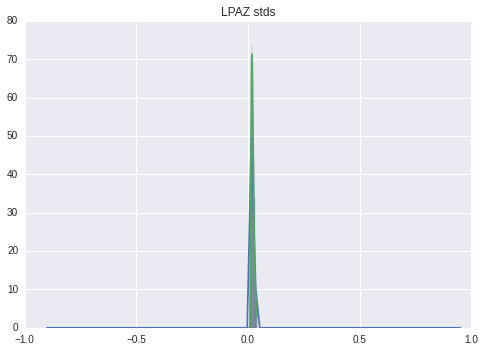

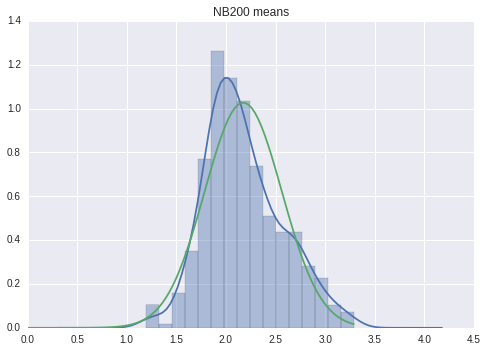

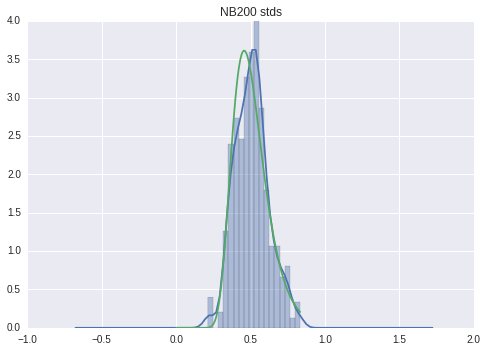

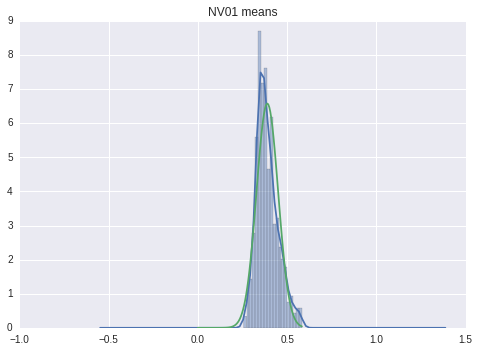

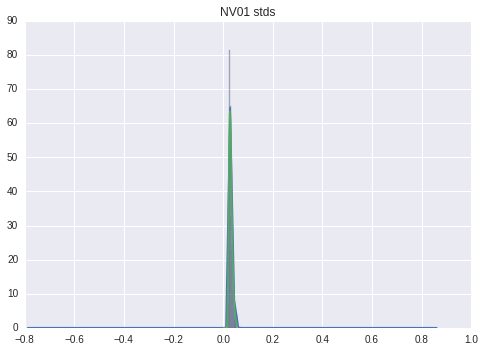

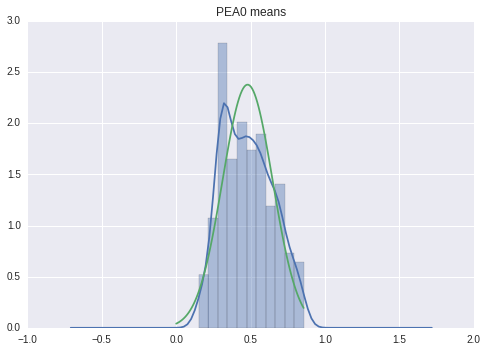

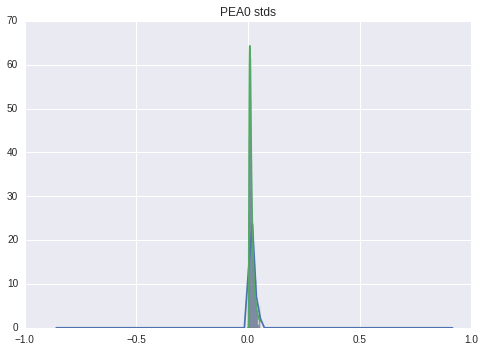

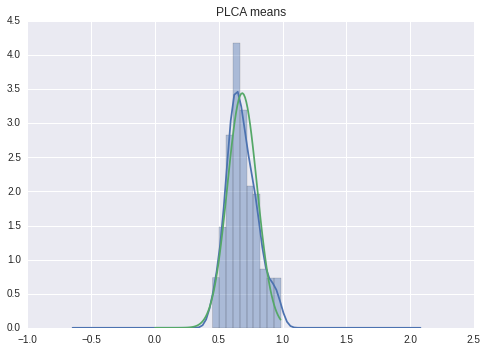

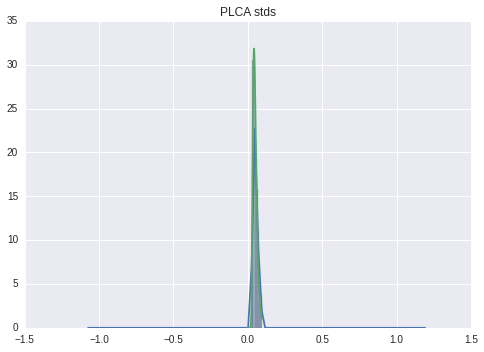

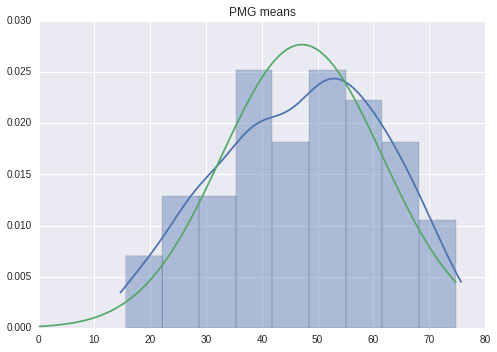

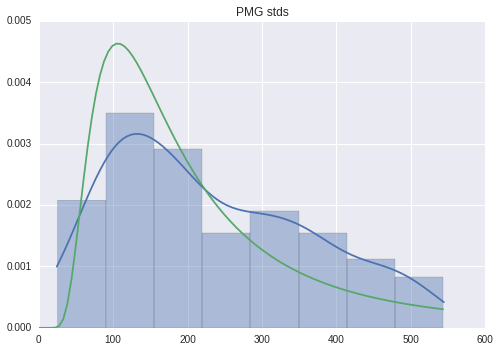

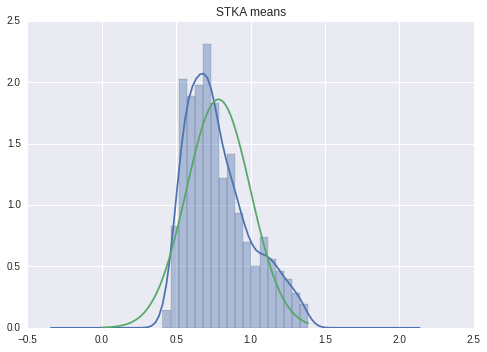

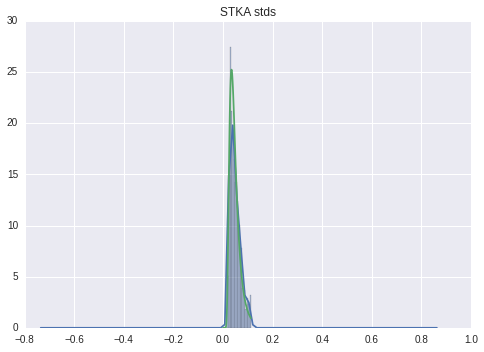

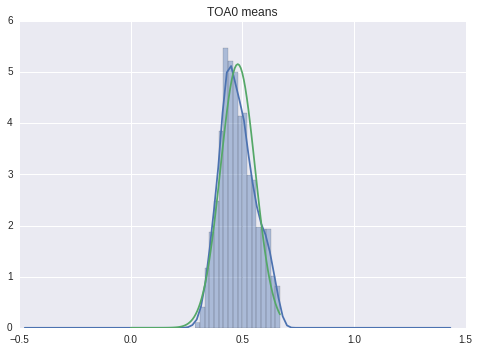

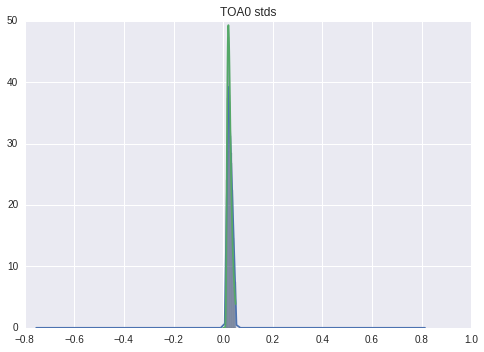

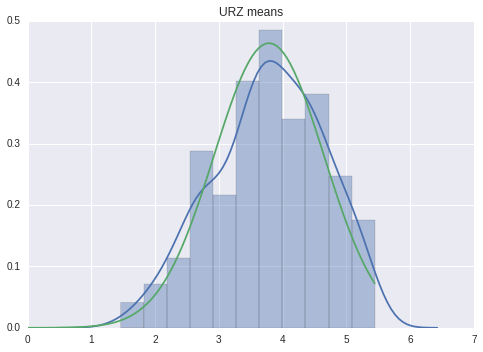

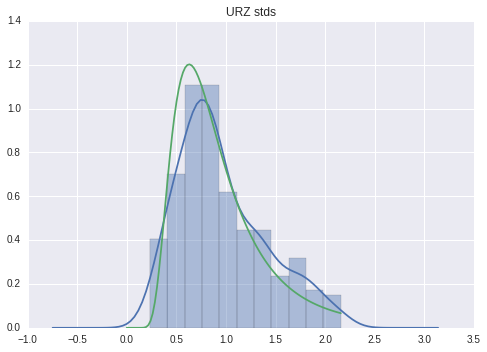

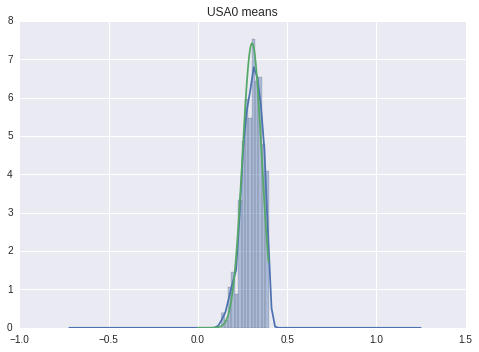

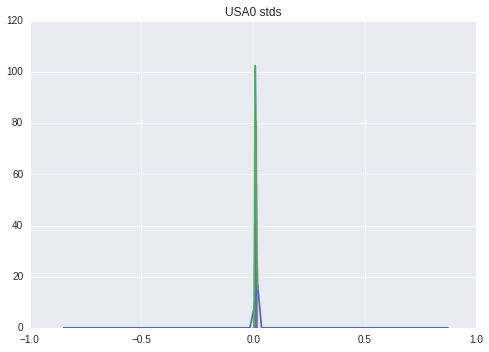

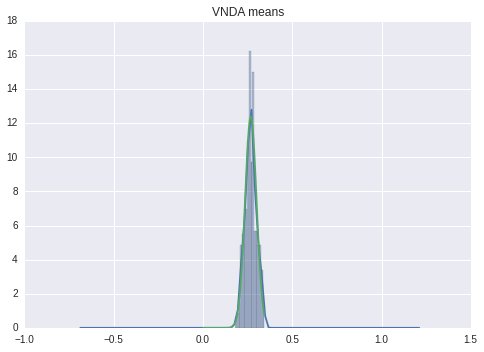

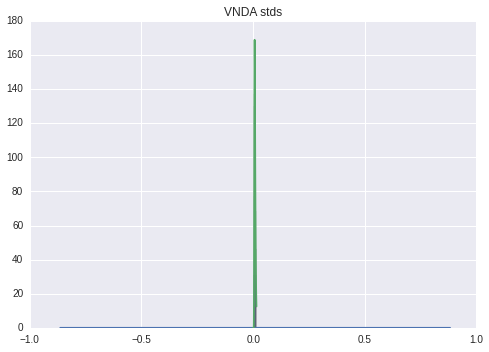

In [3]:



sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
sites=stas = "ASAR,FITZ,ILAR,MKAR,WRA,YKA,KURK,SONM,BVAR,CTA,CMAR,ZALV,AKTO,INK,AAK,AKBB,ARCES,CPUP,DZM,FINES,JKA,KBZ,KSRS,LPAZ,NOA,NVAR,PETK,PLCA,PMG,STKA,TORD,URZ,USRK,VNDA".split(",")
band="freq_0.8_4.5"
hz=5
env=True
llnl=True
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    chan = Sigvisa().default_vertical_channel[sta]
    print sta, chan
    if chan=="sz":
        chan="SHZ"
    if chan=="bz":
        chan="BHZ"
    
    #if sta=="NEW":
    #    cutoff = 50
    #else:
    cutoff = None
        
    #if sta=="ELK":
    #    low_cutoff=10
    #else:
    low_cutoff=None
        
    train_noise_mean_priors(runid=1, sta=sta, band="freq_0.8_4.5", chan=chan, hz=hz, 
                            env=True, mean_upper_cutoff=cutoff,
                            mean_lower_cutoff=low_cutoff)

In [21]:
from sigvisa.learn.train_param_common import load_model



models = load_noise_model_prior(sta="PD31", runid=6)

select model_fname, model_type from sigvisa_param_model where phase='bgnoise' and param='armean' and site='PD31'   and fitting_runid=6 


In [17]:
print np.sqrt(models[1].predict())

8.30332591125


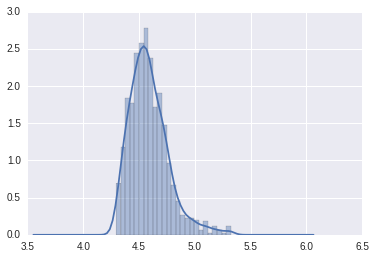

In [74]:
sns.distplot(np.log(censored_means))

1.50544093607 24.9138903827 8.82274453472


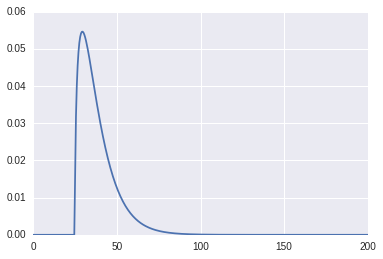

In [69]:
print fit_alpha, fit_loc, fit_beta
xs = np.linspace(0, 200, 400)
plt.plot(xs, rv.pdf(xs))

In [70]:
print fit_alpha, fit_beta, fit_loc

1.50544093607 8.82274453472 24.9138903827
